# IREN - Projet - Adrien Merat

Thsi project aims to classify ships pictures using neural networks.

## 1. Libraries imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rd
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Normalization
import skimage
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

/kaggle/input/navires-2022-a-la-mano/ships.tgz


## 1. Data loading and analysis

We begin by importing the data from the kaggle directory and extract the tarball.

In [2]:
!tar xzf /kaggle/input/navires-2022-a-la-mano/ships.tgz
!ls /kaggle/working/

__notebook_source__.ipynb  ships32  ships_competition.npz


After manually looking at some of the pictures, I have noticed that most of them are colored while some of them are in grey scale. This can make our learning process harder and a simple solution is to get rid of those grey scale images.

We can define a function to test if an image is RGB or grey.

In [3]:
def is_rgb(img):
    """
    Check if a given image is RGB/colored
    """
    return len(img.shape) == 3 and img.shape[2] == 3

We can then count how many grey scale image we have and compare it to the number of all images.

In [4]:
def describe(path):
    """
    Count the number of images as well as the number of grey scale images
    """
    images = []
    non_rgb = []
    
    for directory in np.sort(os.listdir(path)):
        directory = os.path.join(path, directory)
        
        for file in os.listdir(directory):
            file = os.path.join(directory, file)
            image = skimage.io.imread(file)
            images.append(image)
            
            if not is_rgb(image):
                non_rgb.append(image)
                
    width = [img.shape[0] for img in images]
    height = [img.shape[1] for img in images]
                
    print(f"Number of images : {len(images)}")
    print(f"Number of grey scale images : {len(non_rgb)}")
    print(f"Ratio of grey scale images over all images : {round(100*len(non_rgb)/len(images), 2)}%")
    print(f"Minimum image width : {min(width)} px")
    print(f"Maximum image width : {max(width)} px")
    print(f"Minimum image height : {min(height)} px")
    print(f"maximum input height : {max(height)} px")

train_path = "/kaggle/working/ships32"
describe(train_path)

Number of images : 51284
Number of grey scale images : 954
Ratio of grey scale images over all images : 1.86%
Minimum image width : 32 px
Maximum image width : 32 px
Minimum image height : 32 px
maximum input height : 32 px


Thus we can see that all training images have the same size and that the number of grey scale images is quite insignifiant (only 1.86%) which let us remove them without loosing a lot of data to train with. Moreover, using such unappropriate data could make our model return false results.

We can define a function to prepare the data by creating a dataframe with some of its metadata, a list of the images, a list of the labels (as numbers) and a map to correspond label numbers with their corresponding name. This function automatically remove 

In [5]:
def prepare_data(path):
    """
    Extract information of the images and remove grey scale images
    
    :path: Path to the directory containing subdirectories where images are saved
    :return:
        :images: List of the RGB images
        :labels: List of labels of the images
        :df: A dataframe holding caracteristics of the images
        :label_map: A map to link labels to they category name
    """
    labels = []
    images = []
    metadata = []
    current_label = 0
    label_map = {}
    
    for directory in np.sort(os.listdir(path)):
        label_map[current_label] = directory
        directory = os.path.join(path, directory)
        
        for file in os.listdir(directory):
            file = os.path.join(directory, file)
            image = skimage.io.imread(file)
            
            if not is_rgb(image):
                os.remove(file)
            else:
                labels.append(current_label)
                images.append(image)
                metadata.append([file, current_label, image.shape[0], image.shape[1], image.dtype])
                
        current_label += 1
            
    columns = ["filename", "category", "width", "height", "type"]
    df = pd.DataFrame(metadata, columns=columns)
    
    return df, images, np.array(labels), label_map

df, images, labels, label_map = prepare_data(train_path)

print(f"Number of loaded images : {len(images)}")
print(f"Number of labels : {len(label_map)}")
print("List of labels and their corresponding number :")
label_map

Number of loaded images : 50330
Number of labels : 13
List of labels and their corresponding number :


{0: 'coastguard',
 1: 'containership',
 2: 'corvette',
 3: 'cruiser',
 4: 'cv',
 5: 'destroyer',
 6: 'ferry',
 7: 'methanier',
 8: 'sailing',
 9: 'smallfish',
 10: 'submarine',
 11: 'tug',
 12: 'vsmallfish'}

Our images have all the same size which will make our work way more easier. Now let's take a look at the competition images :

In [6]:
competition_path = '/kaggle/working/ships_competition.npz'
competition = np.load(competition_path, allow_pickle=True)["X"]
competition = competition.astype(float) / 255
print(f"Number of images : {competition.shape[0]}")
print(f"Images width : {competition.shape[1]} px")
print(f"Images height : {competition.shape[2]} px")
print(f"Number of color channels : {competition.shape[3]}")

Number of images : 1968
Images width : 32 px
Images height : 32 px
Number of color channels : 3


Competition images are in the same format as training ones, which is perfect.

We will now see how well are the different categories represented among our dataset.

Text(0.5, 1.0, 'Number of images per category of boat')

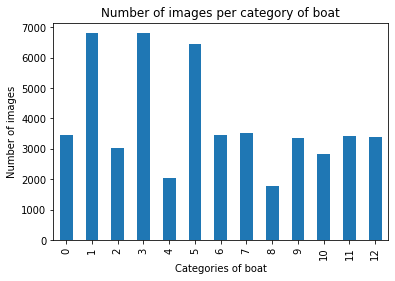

In [7]:
plot = df['category'].value_counts(sort=False).plot.bar()
plot.set_xlabel("Categories of boat")
plot.set_ylabel("Number of images")
plot.set_title("Number of images per category of boat")

The 8th category (sailing boat) seems to be the least represented one, we print here its count :

In [8]:
min_img = len(df[df['category'] == 8])
min_img

1770

We can see that our dataset is not well balanced at all which can reduce our model quality. We can fix this by augmenting our dataset on the least represented categories.

## 3. Data transformations

Before proceeding to the data augmentation we need to split the dataset in three parts : train set, validation set and test set. Augmenting the dataset before splitting it will cause data leakage as the synthetic data consists of linear combinations of your training data. Our classifier will perform outstanding on your incorrectly created test data and later poorly on real unseen data in production. That's why we first split our dataset.

### 3.1. Splitting dataset

We will use `keras.ImageDataGenerator` to handle our 3 datasets. It requires to have 2 directories, one for train and validation and the other one for ths test. Thus we will create two folders `/kaggle/working/train` and `kaggle/working/test`. The test folder needs to have the same number of images per category to be unbiased.

In [9]:
!mkdir /kaggle/working/test
!cp /kaggle/working/ships_32 /kaggle/working/train

cp: cannot stat '/kaggle/working/ships_32': No such file or directory


In [10]:
def split_dataset(input, output, label_map, img_per_category=None):
    """
    Split the dataset by moving some images from the input (train)
    directory to the output (test) directory.
    
    :input: The path to the input folder
    :output: The path to the output folder
    :label_map: A map between label numbers and name on our dataset
    :img_per_category: Number of images per category we want in our datasets
    """
    for key, category in label_map.items():
        category_path = os.path.join(input, category)
        test_category_path = os.path.join(output, category)
        os.mkdir(test_category_path)
        
        for file in os.listdir(category_path)[:img_per_category]:
            os.rename(os.path.join(category_path, file), os.path.join(test_category_path, file))
            
test_path = "/kaggle/working/test"
split_dataset(train_path, test_path, label_map, 100)

We choose to take 200 images of each category and move them in the test folder.

### 3.2. Data augmentation

In order to augment create a better model, we will augment the size of ourr dataset by applying random operators to some images such as horizontal flip, noise, rotation (small) or constrast. Because our images are very small, it would make no sense to use random zoom and because boats floats on water, the use of huge angle rotatiosn, as weel as vertical flip would make no sense in our use case.

We will also need preprocess our images in order to scale them to fit them into the interval $[0,1]$ as scaled dataset always produce better results. We will use the Keras `ImageDataGenerator` to handle images loading and preprocessing as it load data on the fly which is more memory efficient.

#### 3.2.1. Test dataset

For the test dataset, we don't need to apply data augmentation as they will be used to check the model's predictions.

In [11]:
!mkdir /kaggle/working/keras_test

In [12]:
from keras.preprocessing.image import ImageDataGenerator

test_imgdatagenerator = ImageDataGenerator(rescale=1./255, dtype='float32')

test_generator = test_imgdatagenerator.flow_from_directory(
        test_path,
        target_size=(32, 32),
        seed=SEED,
        shuffle=False,
        save_to_dir='/kaggle/working/keras_test',
        save_format="jpeg",
        interpolation="bicubic")

Found 1300 images belonging to 13 classes.


### 3.2.2. Train Dataset

This time, we will need to split the train dataset in a train and validation set. We choose to teake respectively 90% and 10% of the current train dataset. On top of that we will do some data augmentation to improve the model by duplicating some images and applying them some minor transformations.

In [13]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 10
    deviation = VARIABILITY * rd.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_imgdatagenerator = ImageDataGenerator(rescale=1./255,
                                            width_shift_range=.2,
                                            height_shift_range=.2,
                                            horizontal_flip=True,
                                            rotation_range=0,
                                            validation_split=0.1,
                                            featurewise_center=True,
                                            preprocessing_function=add_noise,
                                            dtype='float32')

train_generator = train_imgdatagenerator.flow_from_directory(
        train_path,
        batch_size=32,
        target_size=(32,32),
        seed=SEED,
        subset="training",
        interpolation="bicubic")

validation_generator = train_imgdatagenerator.flow_from_directory(
        train_path,
        batch_size=32,
        target_size=(32,32),
        seed=SEED,
        subset="validation",
        interpolation="bicubic")

Found 44132 images belonging to 13 classes.
Found 4898 images belonging to 13 classes.


### 3.2.3. Preprocessing

Here we setup preprocessing for our model inference.

In [14]:
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomContrast, Rescaling

preprocessing = Sequential([
    Rescaling(1.0 / 255),
    RandomRotation(25./360, seed=SEED),
    RandomContrast(0.75, seed=SEED),
    RandomFlip("horizontal", seed=SEED)])

2022-07-09 19:03:00.319375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 19:03:00.457572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 19:03:00.458817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 19:03:00.461819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 4. Model

### 4.1. Model creation

We base our neural network on a VGG (Visual Geometry Group) network. To better analyze images' content, we are gonna use a CNN (Convolutional Neural Network) which will first apply a convolution operator of 3x3 px on the image (one per color channel). Then we apply a max pooling to downsample the input by keeping maximum values and a batch normalization to keep mean around 0 and standard deviation around 1 so the CNN converges faster. After, we apply a dropout of 10% to avoid overfitting by dropping 10% of the nodes. We repeat this cycle 4 times and finally we apply a global average pooling to average each array of data and a dense layer to connect to all neurons. 

We use the relu function for activatio, as it is very performant, on every layer except for the last one where we use a softmax in order to return a probability (*i.e.* a value in $[0,1]$).

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta

input_shape = (32, 32, 3)
model = Sequential()

#model.add(RandomContrast(0.5, seed=SEED))

# First cycle
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# Second cycle
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# Third cycle
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# Fourth cycle
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# Averaging and densing
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))

model.compile(optimizer=Adadelta(learning_rate=0.05), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

### 4.2. Model training

We use the train and validation datasets to train our model using the previously defined image data generators. We will use a callback to keep a trace of the best weights during the training as they will vary and might get inaccurate on the last trainings.

In [16]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = '/kaggle/working/model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

epochs = 100

model_history = model.fit(x=train_generator,
                          epochs=epochs,
                          verbose=1,
                          validation_data=validation_generator,
                          callbacks=[model_checkpoint_callback])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-07-09 19:03:05.066309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-09 19:03:08.120259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1380/1380 [==============================] - 104s 68ms/step - loss: 2.0757 - accuracy: 0.3144 - val_loss: 1.7473 - val_accuracy: 0.4204

Epoch 00001: val_accuracy improved from -inf to 0.42038, saving model to /kaggle/working/model_checkpoint
Epoch 2/100
1380/1380 [==============================] - 90s 65ms/step - loss: 1.7111 - accuracy: 0.4336 - val_loss: 1.5065 - val_accuracy: 0.5006

Epoch 00002: val_accuracy improved from 0.42038 to 0.50061, saving model to /kaggle/working/model_checkpoint
Epoch 3/100
1380/1380 [==============================] - 91s 66ms/step - loss: 1.5042 - accuracy: 0.4997 - val_loss: 1.3223 - val_accuracy: 0.5590

Epoch 00003: val_accuracy improved from 0.50061 to 0.55900, saving model to /kaggle/working/model_checkpoint
Epoch 4/100
1380/1380 [==============================] - 89s 64ms/step - loss: 1.3649 - accuracy: 0.5432 - val_loss: 1.2147 - val_accuracy: 0.5904

Epoch 00004: val_accuracy improved from 0.55900 to 0.59045, saving model to /kaggle/working/mod

Our model get a quite good accuracy over the validation dataset with 79,747%, but we need to check it against the test dataset to be sure we didn't nake any overfitting.

### 4.3. Model's training results

We plot bellow a comparaison of the train and validation accuracy and loss over epochs.

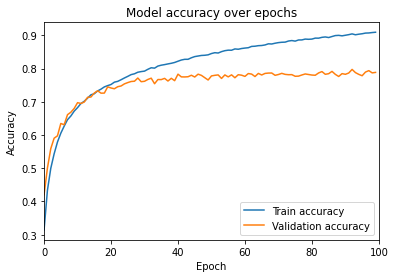

In [17]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, epochs])
plt.legend(['Train accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

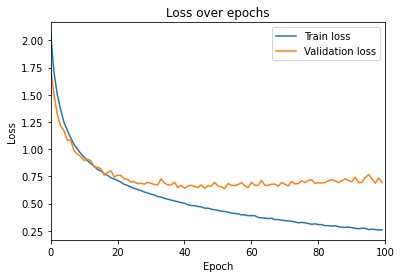

In [18]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, epochs])
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [19]:
max_train_accuracy = model_history.history['accuracy'][-1]
max_val_accuracy = model_history.history['val_accuracy'][-1]
print(f"The maximum accuracy on the train dataset is {round(max_train_accuracy * 100, 2)}%")
print(f"The maximum accuracy on the validation dataset is {round(max_val_accuracy * 100, 2)}%")

The maximum accuracy on the train dataset is 90.93%
The maximum accuracy on the validation dataset is 78.85%


We can see that the model converges very quickly on the firsts epochs and then quite slower. The train accuracy reach around 91% on the last epoch, and the validation accuracy around 79%. We can see that the model stuck after the 20th or 30th epoch as its loss starts to freeze. Hopefully we used a callback to prevent overfitting in such situations.

#### 4.3.1. Model accuracy

Below we compute the accuracy of our model against the test dataset :

In [20]:
model.load_weights(checkpoint_path)
metric = model.evaluate(test_generator)
print(f"Model's accurary on test dataset : {metric[1] * 100}%")

41/41 [==============================] - 2s 39ms/step - loss: 0.7581 - accuracy: 0.7838
Model's accurary on test dataset : 78.38461399078369%


The accuracy against the test dataset is pretty good with 78.38%, considering the small size of images and limited data augmentation techniques.

#### 4.3.2. Confusion matrix

The model didn't overfit our training and validation dataset which is a very good news.  We will now plot a confusion matrix of our model against the test dataset to see on which categories it has more difficulties. But first we save our model.

In [21]:
model.save(filepath='/kaggle/working/model')

2022-07-09 21:35:08.163110: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Then we create a small function to plot the confusion matruix using a heatmap to better see the values. The closer to 100 the values on the diagonal, the closest to real label our model is.

In [22]:
import seaborn as sn

def plot_confusion_matrix(conf_matrix, categories, title="Confusion matrix"):
    confusion_df = pd.DataFrame(conf_matrix, categories, categories)
    plt.figure(figsize=(10,8))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(confusion_df, cmap='rocket_r', fmt='g', annot=True, annot_kws={"size": 12})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)

In [23]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix of the model
y_pred = model.predict(test_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

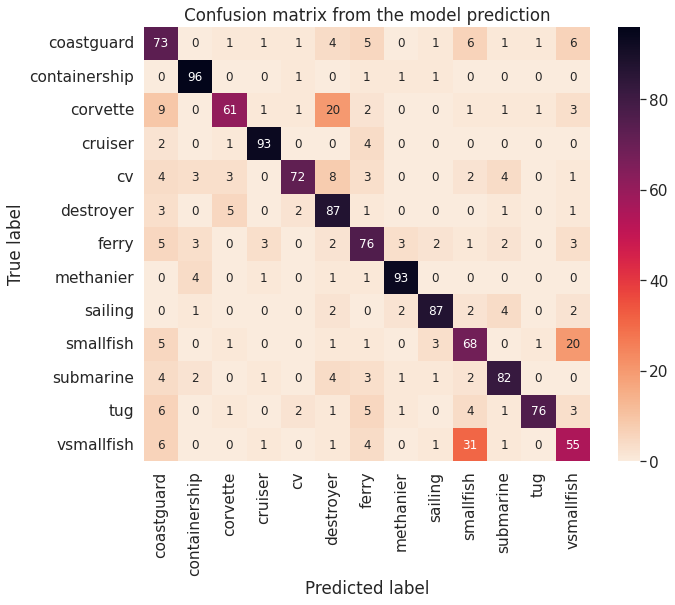

In [24]:
plot_confusion_matrix(conf_matrix, label_map.values(), title="Confusion matrix from the model prediction")

We can see our model struggles with some categories such as corvette vs destroyer or smallfish vs vsmallfish. This can be explain by the poor resolution of the dataset and the fact that those kind of boat are very similar in real life.

## 5. Submission

Bellow are the steps to submit to the leaderboard.

In [25]:
submission_file = '/kaggle/working/ships_competition.npz'
X_submission = np.load(submission_file, allow_pickle=True)["X"]

#X_submission = preprocessing(X_submission.astype(float)).numpy()
X_submission = X_submission.astype(float)/255

res = model.predict(X_submission).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv